In [2]:
%matplotlib widget

In [3]:
from diffSPH.v2.parameters import parseDefaultParameters, printDefaultParameters, parseModuleParameters
from diffSPH.v2.sampling import sampleRegular, emitParticlesRegular, emitParticlesSDF
from diffSPH.v2.math import volumeToSupport
from diffSPH.v2.neighborhood import fluidNeighborSearch
from diffSPH.v2.sphOps import sphOperationFluidState
from torchCompactRadius.util import countUniqueEntries
from diffSPH.v2.plotting import scatterPlotFluid, scatterPlotFluidSymmetric, plotImplicitSDF
from diffSPH.v2.modules.normalizationMatrices import computeNormalizationMatrices
from diffSPH.v2.modules.surfaceDetection import computeNormalsMaronne, detectFreeSurfaceMaronne
from diffSPH.v2.modules.surfaceDetection import computeColorField, computeColorFieldGradient
from diffSPH.v2.modules.surfaceDetection import detectFreeSurfaceColorField, detectFreeSurfaceColorFieldGradient
from diffSPH.v2.modules.surfaceDetection import detectFreeSurfaceBarecasco
from diffSPH.v2.modules.surfaceDetection import computeSurfaceDistance, getStableSurfaceNormal
import matplotlib.pyplot as plt
import torch
import numpy as np
from diffSPH.v2.sdf import getSDF, sdfFunctions, operatorDict

In [4]:
config = {
    'domain': {
        'minExtent': -1,
        'maxExtent': 1,
    },
}

config = parseDefaultParameters(config)
config = parseModuleParameters(config)

display(config)

{'domain': {'minExtent': tensor([-1., -1.]),
  'maxExtent': tensor([1., 1.]),
  'dim': 2,
  'periodic': True,
  'periodicity': tensor([True, True])},
 'particle': {'nx': 64,
  'dx': tensor(0.0312),
  'defaultVolume': tensor(0.0010),
  'defaultSupport': 0.12466946262544772,
  'volume': tensor(0.0010),
  'support': 0.12466946262544772},
 'compute': {'device': 'cpu', 'precision': 'float32', 'dtype': torch.float32},
 'kernel': {'name': 'Wendland4',
  'targetNeighbors': 50,
  'function': <diffSPH.kernels.KernelWrapper at 0x7f56c6dfb970>},
 'integration': {'dt': 0.01,
  'adaptiveTimestep': False,
  'CFL': 0.25,
  'maxDt': 0.1,
  'minDt': 0.001},
 'simulation': {'correctArea': False},
 'fluid': {'rho0': 1, 'mu': 0.01},
 'surfaceDetection': {'colorFieldGradientThreshold': 10.0,
  'colorFieldThreshold': 0.8,
  'BarecascoThreshold': 1.0471975511965976,
  'distanceIterations': 16}}

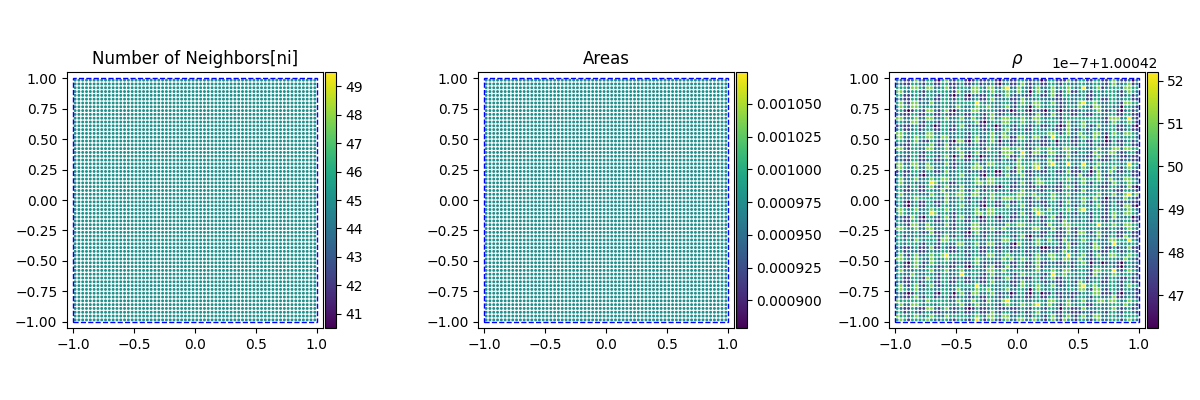

In [5]:
simulationState = {}

p, areas, supports, velocities = emitParticlesRegular(config['particle']['dx'], config['domain']['minExtent'], config['domain']['maxExtent'], config)

simulationState['fluidPositions'] = p
simulationState['fluidAreas'] = areas
simulationState['fluidMasses'] = areas * config['fluid']['rho0']
simulationState['fluidSupports'] = supports
simulationState['fluidVelocities'] = velocities

simulationState['numParticles'] = p.shape[0]

simulationState['fluidNeighborhood'] = fluidNeighborSearch(simulationState, config)
simulationState['fluidDensities'] = sphOperationFluidState(simulationState, None, 'density')
_, simulationState['fluidNumNeighbors'] = countUniqueEntries(simulationState['fluidNeighborhood']['indices'][0], simulationState['fluidPositions'])

fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
scatterPlotFluid(fig, axis[0,0], simulationState, config, simulationState['fluidNumNeighbors'], 'Number of Neighbors[ni]')
scatterPlotFluid(fig, axis[0,1], simulationState, config, simulationState['fluidAreas'], 'Areas')
scatterPlotFluid(fig, axis[0,2], simulationState, config, simulationState['fluidDensities'], '$\\rho$')
fig.tight_layout()

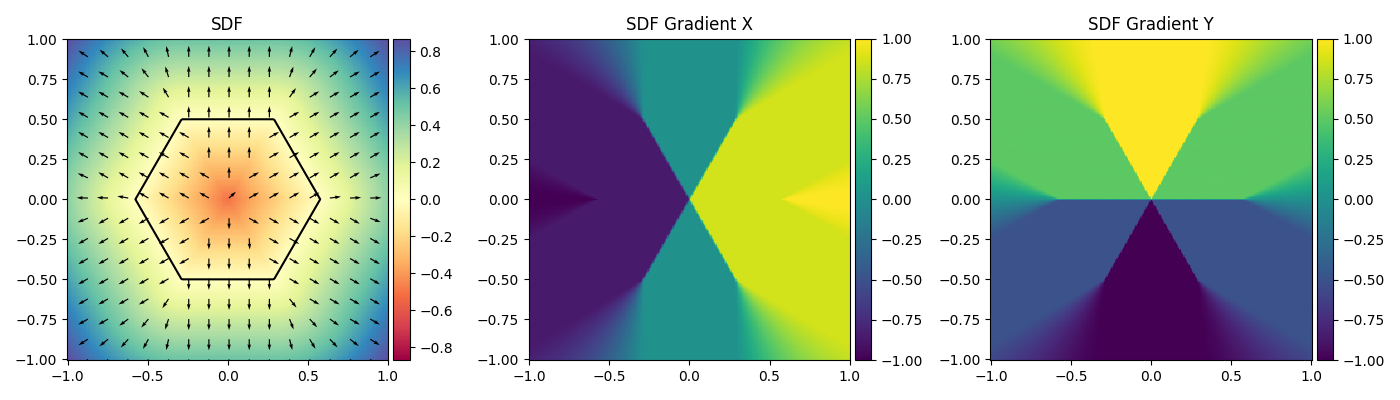

In [6]:
ngrid = 255
x = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
y = torch.linspace(-1, 1, ngrid, dtype = torch.float32)
X, Y = torch.meshgrid(x, y, indexing = 'ij')
P = torch.stack([X,Y], dim=-1)
points = P.reshape(-1,2)

sphere_a = lambda points: getSDF('hexagon')['function'](points, 0.5)
sphere_b = lambda points: getSDF('box')['function'](points, torch.tensor([0.25,0.5]))
translated = operatorDict['translate'](sphere_b, torch.tensor([0.1,0.25]))
rotated = operatorDict['rotate'](translated, 0.5)
sdf = operatorDict['smooth_union'](rotated, sphere_a, 0.25)
sdf = sphere_a

# circle_a = operatorDict['translate'](lambda points: getSDF('hexagon')['function'](points, 0.35), torch.tensor([-0.25,0.]))
# circle_b = operatorDict['translate'](lambda points: getSDF('circle')['function'](points, 0.35), torch.tensor([ 0.25,0.]))
# sdf = operatorDict['smooth_union'](circle_a, circle_b, 0.05)
# sdf = operatorDict['twist'](sdf, 0.5)
# sdf = operatorDict['shell'](sdf, 0.125)

plotImplicitSDF(sdf, ngrid = 255, minExtent = -1, maxExtent = 1)

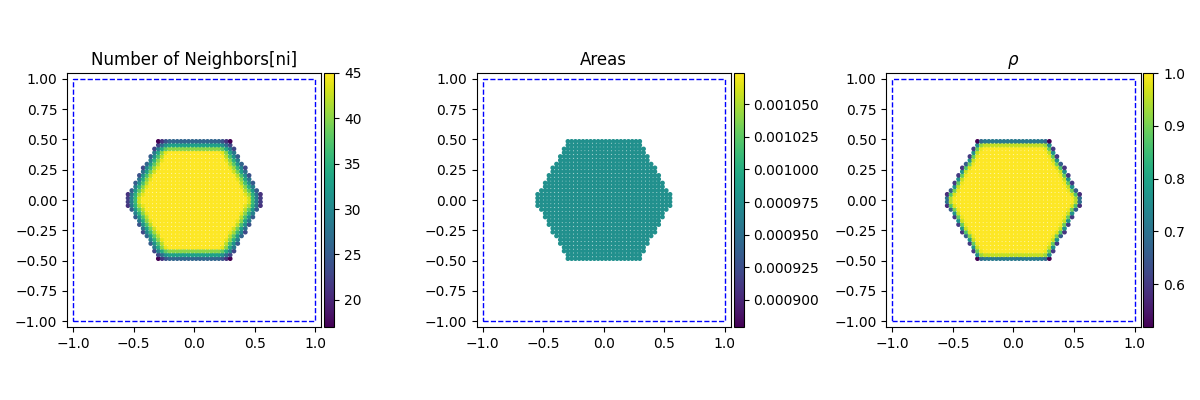

In [7]:
simulationState = {}

p, areas, supports, velocities = emitParticlesSDF(sdf, config['particle']['dx'], config['domain']['minExtent'], config['domain']['maxExtent'], config, 0.0)

simulationState['fluidPositions'] = p
simulationState['fluidAreas'] = areas
simulationState['fluidMasses'] = areas * config['fluid']['rho0']
simulationState['fluidSupports'] = supports
simulationState['fluidVelocities'] = velocities
simulationState['numParticles'] = p.shape[0]

simulationState['fluidNeighborhood'] = fluidNeighborSearch(simulationState, config)
simulationState['fluidDensities'] = sphOperationFluidState(simulationState, None, 'density')
_, simulationState['fluidNumNeighbors'] = countUniqueEntries(simulationState['fluidNeighborhood']['indices'][0], simulationState['fluidPositions'])

fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
scatterPlotFluid(fig, axis[0,0], simulationState, config, simulationState['fluidNumNeighbors'], 'Number of Neighbors[ni]')
scatterPlotFluid(fig, axis[0,1], simulationState, config, simulationState['fluidAreas'], 'Areas')
scatterPlotFluid(fig, axis[0,2], simulationState, config, simulationState['fluidDensities'], '$\\rho$')
fig.tight_layout()


In [8]:
simulationState['fluidL'], normalizationMatrices, simulationState['L.EVs'] = computeNormalizationMatrices(simulationState, config)

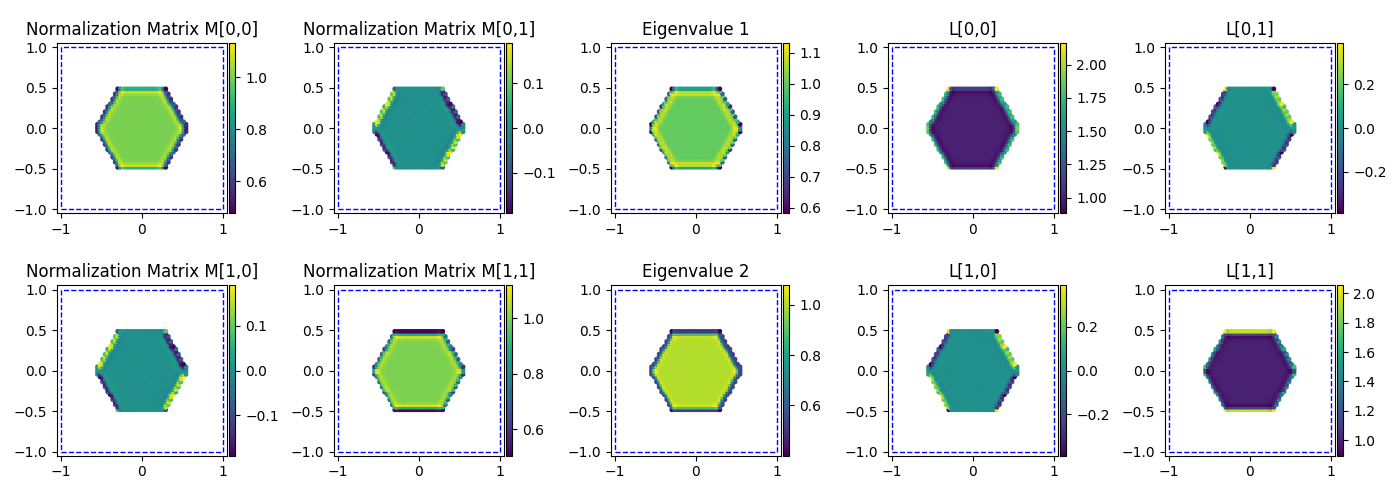

In [9]:
fig, axis = plt.subplots(2, 5, figsize=(14,5), sharex = False, sharey = False, squeeze = False)
scatterPlotFluid(fig, axis[0,0], simulationState, config, normalizationMatrices[:,0,0], 'Normalization Matrix M[0,0]')
scatterPlotFluid(fig, axis[0,1], simulationState, config, normalizationMatrices[:,0,1], 'Normalization Matrix M[0,1]')
scatterPlotFluid(fig, axis[1,0], simulationState, config, normalizationMatrices[:,1,0], 'Normalization Matrix M[1,0]')
scatterPlotFluid(fig, axis[1,1], simulationState, config, normalizationMatrices[:,1,1], 'Normalization Matrix M[1,1]')

scatterPlotFluid(fig, axis[0,2], simulationState, config, simulationState['L.EVs'][:,0], 'Eigenvalue 1')
scatterPlotFluid(fig, axis[1,2], simulationState, config, simulationState['L.EVs'][:,1], 'Eigenvalue 2')

scatterPlotFluid(fig, axis[0,3], simulationState, config, simulationState['fluidL'][:,0,0], 'L[0,0]')
scatterPlotFluid(fig, axis[0,4], simulationState, config, simulationState['fluidL'][:,0,1], 'L[0,1]')
scatterPlotFluid(fig, axis[1,3], simulationState, config, simulationState['fluidL'][:,1,0], 'L[1,0]')
scatterPlotFluid(fig, axis[1,4], simulationState, config, simulationState['fluidL'][:,1,1], 'L[1,1]')

fig.tight_layout()

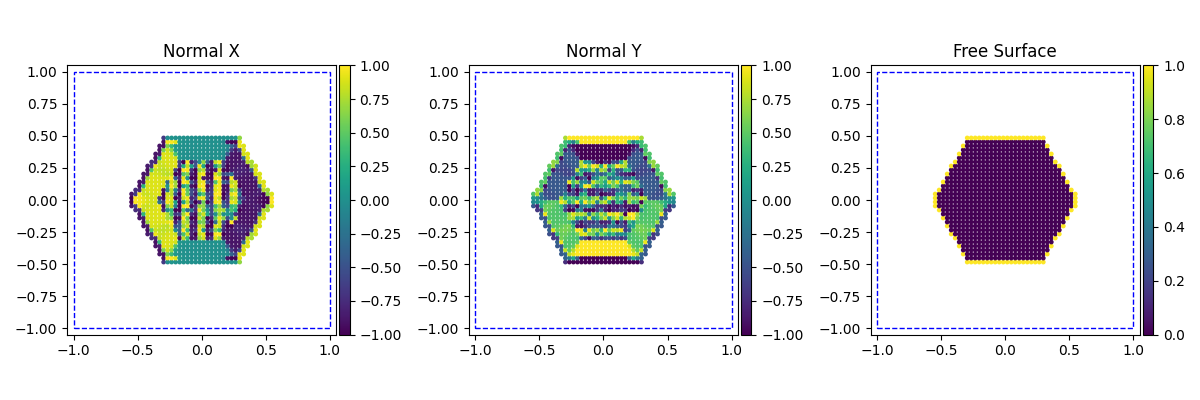

In [10]:
simulationState['fluidNormals'], _ = computeNormalsMaronne(simulationState, config)
simulationState['fluidFreeSurface'], cA, cB = detectFreeSurfaceMaronne(simulationState, config)

fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
scatterPlotFluidSymmetric(fig, axis[0,0], simulationState, config, simulationState['fluidNormals'][:,0], 'Normal X')
scatterPlotFluidSymmetric(fig, axis[0,1], simulationState, config, simulationState['fluidNormals'][:,1], 'Normal Y')
scatterPlotFluid(fig, axis[0,2], simulationState, config, simulationState['fluidFreeSurface'], 'Free Surface')
fig.tight_layout()


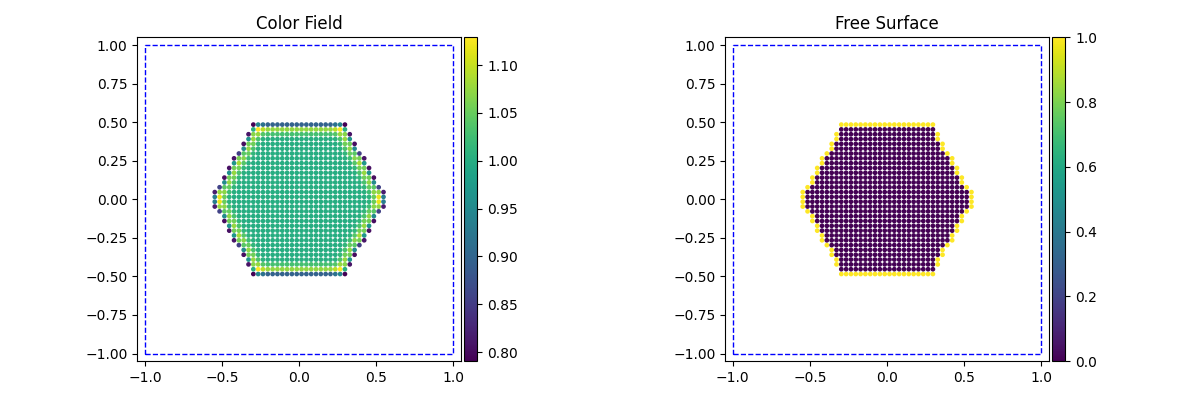

In [11]:
simulationState['fluidColor'] = computeColorField(simulationState, config)
simulationState['fluidFreeSurface'] = detectFreeSurfaceColorField(simulationState, config)

fig, axis = plt.subplots(1, 2, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
scatterPlotFluid(fig, axis[0,0], simulationState, config, simulationState['fluidColor'], 'Color Field')
scatterPlotFluid(fig, axis[0,1], simulationState, config, simulationState['fluidFreeSurface'], 'Free Surface')

fig.tight_layout()

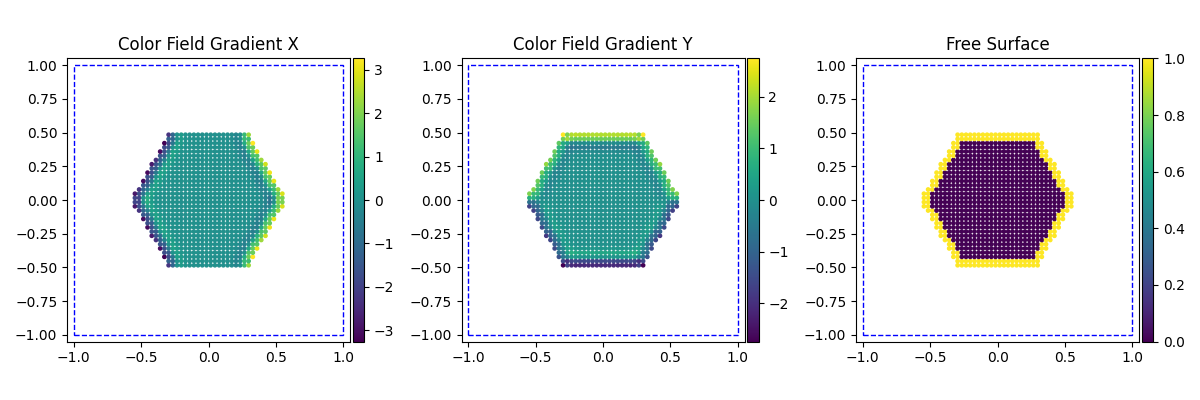

In [12]:
simulationState['fluidColorGradient'] = computeColorFieldGradient(simulationState, config)
simulationState['fluidFreeSurface'] = detectFreeSurfaceColorFieldGradient(simulationState, config)

fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
scatterPlotFluidSymmetric(fig, axis[0,0], simulationState, config, simulationState['fluidColorGradient'][:,0], 'Color Field Gradient X')
scatterPlotFluidSymmetric(fig, axis[0,1], simulationState, config, simulationState['fluidColorGradient'][:,1], 'Color Field Gradient Y')
scatterPlotFluid(fig, axis[0,2], simulationState, config, simulationState['fluidFreeSurface'], 'Free Surface')

fig.tight_layout()

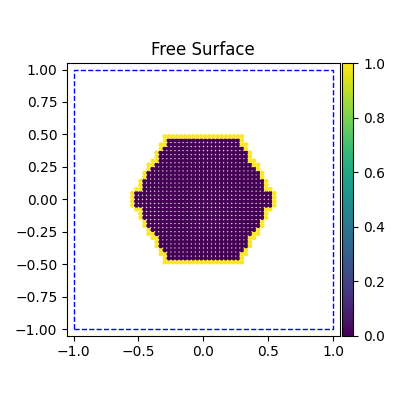

In [13]:
simulationState['freeSurface'] = detectFreeSurfaceBarecasco(simulationState, config)

fig, axis = plt.subplots(1, 1, figsize=(4,4), sharex = False, sharey = False, squeeze = False)
scatterPlotFluid(fig, axis[0,0], simulationState, config, simulationState['freeSurface'], 'Free Surface')

fig.tight_layout()

tensor(35584908.)
tensor(25674658.)
tensor(17566500.)
tensor(8107447.5000)
tensor(2.8665e-07)
tensor(0.0312)


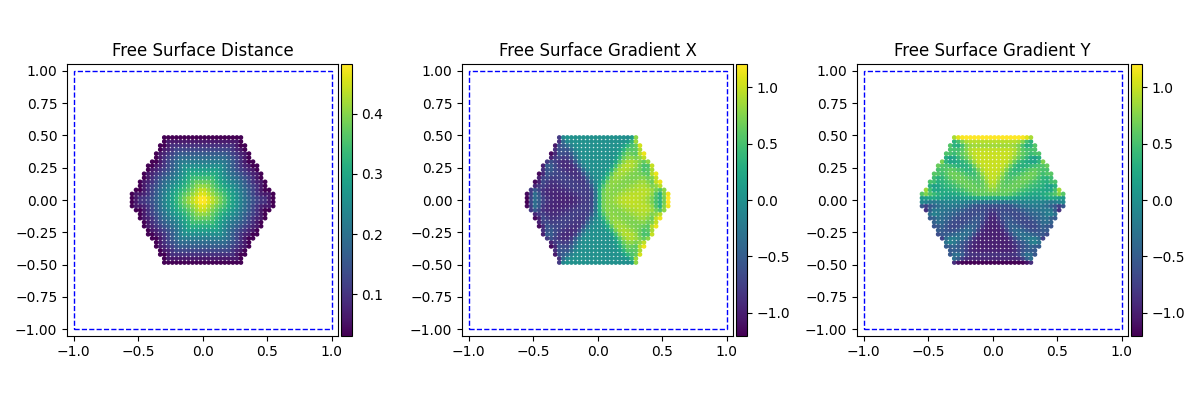

In [14]:
simulationState['surfaceDistance'] = computeSurfaceDistance(simulationState, config)
simulationState['surfaceDistanceNormal'] = getStableSurfaceNormal(simulationState, config)


fig, axis = plt.subplots(1, 3, figsize=(12,4), sharex = False, sharey = False, squeeze = False)
scatterPlotFluid(fig, axis[0,0], simulationState, config, simulationState['surfaceDistance'], 'Free Surface Distance')
scatterPlotFluidSymmetric(fig, axis[0,1], simulationState, config, simulationState['surfaceDistanceNormal'][:,0], 'Free Surface Gradient X')
scatterPlotFluidSymmetric(fig, axis[0,2], simulationState, config, simulationState['surfaceDistanceNormal'][:,1], 'Free Surface Gradient Y')

fig.tight_layout()
print(config['particle']['dx'])